In [2]:
import numpy as np
from itertools import product
from dataclasses import dataclass
import matplotlib.pyplot as plt

Ref: https://github.com/jomavera/optimizationAlgosPort/blob/main/chap_14.ipynb

In [3]:
perm = np.random.permutation(10)
perm

array([9, 4, 5, 2, 1, 8, 6, 3, 0, 7])

In [5]:
i = 1; m = 10; k = 5

np.setdiff1d(np.arange(i,m), np.arange(i,m,k))

array([2, 3, 4, 5, 7, 8, 9])

In [7]:
perm[i:m:k]

array([4, 6])

# Algorithm 14.5 + 14.6

In [17]:
def radial_bases(psi, C, p=2):
    '''
    - psi: a radial function
    - C: list of centers
    - p: L_p norm (default: L2)
    '''
    bases = [] # list of basis function, containing b_i(x)
    for c in C:
        func = lambda x, c=c: psi(np.linalg.norm(x-c, p)) # psi(||x-x^(i)||), với c = x^(i)
        bases.append(func)
    return bases

def regression(X, y, bases, lamb):
    B = np.array([[b(x) for b in bases] for x in X]) # basis matrix
    theta = np.linalg.inv((B.T @ B + lamb * np.identity(len(bases)))) @ B.T @ y
    # theta = np.linalg.solve(np.matmul(B.T,B) + np.diag(lamb*np.ones((len(bases),1))),np.matmul(B.T,y))
    return lambda x: np.sum([theta[i]*bases[i](x) for i in range(len(theta))])

## Algorithm 14.7:

In [18]:
@dataclass
class TrainTest:
    train: list
    test: list
    
def train_and_validate(X, y, tt, fit, metric):
    model = fit(X[tt.train], y[tt.train])
    return metric(model, X[tt.test], y[tt.test])

# TEST

In [19]:
def polynomial_bases_1d(i,k): # polynomial cho 1 cột của x: 1,x,x^2,x^3,...
    f = lambda x: np.power(x[i], np.arange(0,k+1,1))
    return f

def polynomial_bases(n,k):
    bases = [polynomial_bases_1d(i, k) for i in range(n)]
    terms = []
    i = 0
    
    for ks in product(*[np.arange(0,k+1) for _ in range(n)]): # cartesian product: [[0,0], [0,1],...,(3,3)]
        if np.sum(ks) <= k: # DK trong CT 14.19: i+j<=k
            def func(x, ks=ks):
                res = np.prod([b(x)[j] for j, b in zip(ks,bases)]) # CT 14.19 tính b_{ij}(x) = x_1^i * x_2^j
                # print(x, ks, res)
                return res 
            terms.append(func)
            
            # print('terms: ', i)
            # i+=1

    return terms

In [ ]:
##
n, k = 2, 3 # 1 data point có 2 cột
x = [2,3]
bases = [polynomial_bases_1d(i, k) for i in range(n)] # với từng thuộc tính (col), mũ hóa nó lên

for ks in product(*[np.arange(0,k+1) for i in range(n)]): # loop qua từng mũ có thể có: [[0,0], [0,1],...,(3,3)]
    if np.sum(ks) <= k:
        print(f'ks: {ks}')

        l = np.prod([b(x)[j] for j, b in zip(ks,bases)]) # tính b_{ij}(x) = x_1^i * x_2^j, lưu trong terms, chú ý term khác với parameter theta
        print(l)
        # break
    # break
    # print(np.sum(ks))
    

- test 1

In [27]:
np.random.seed(35912)
bases = polynomial_bases(2,3)
X = np.array([[1.0, 5.0],
              [2.0, 2.0],
              [3.0, 2.0],
              [4.0, 2.0]])

y = np.array([2, 2, 5, 8]).reshape(-1,1)

lmb=[0.3 for i in range(len(bases))]
model = regression(X,y,bases,lmb)
print(model([4,6,7]))

35.52256700620834


In [ ]:
len(bases) # do có 10 ks thỏa <= k

10

- test 2

In [29]:
# algo 14.10
def k_fold_cross_validation_sets(m, k):
    perm = np.random.permutation(m)
    sets = []
    for i in range(k):
        validate = perm[i:m:k]
        train = perm[np.setdiff1d(np.arange(i,m),np.arange(i,m,k))]
        sets.append(TrainTest(train, validate))
    return sets

def cross_validation_estimate(X, y, sets, fit, metric):
    return np.mean([train_and_validate(X, y, tt, fit, metric) for tt in sets])

In [30]:
np.random.seed(0)
f = lambda x:np.sin(2*x)*np.cos(10*x)

# ---- Data generated in Julia with seed 0 to resemble results from book ---- #
X = np.array([0.8236475079774124, 
0.9103565379264364, 
0.16456579813368521, 
0.17732884646626457, 
0.278880109331201, 
0.20347655804192266,
0.042301665932029664,
0.06826925550564478,
0.3618283907762174,
0.9732164043865108]).reshape(-1,1)

y =np.array([ -0.4410340396417118,
 -0.9956556536332956,
  0.015573949795123155,
  0.01132320974198503,
 -0.5313248333867803,
 -0.19588413875990168,
 -0.08367168413613427,
 -0.14247105758074852,
 -0.3606906314525021,
 -0.8647008769320896]).reshape(-1,1)

# ------------------------------------------- #


sets = k_fold_cross_validation_sets(X.shape[0],3)

def metric(f, X, y): # MSE metric
    m = X.shape[0]
    return np.sum([(f(X[i])-y[i])**2 for i in range(m)])/m

lambda_s = 10**np.linspace(-4,2,101, dtype=np.float64)
es = []
basis = lambda r: np.exp(-5*r**2)
for lambd in lambda_s:
    def fit(X,y,lambd=lambd):
        bases = radial_bases(basis,X)
        return regression(X, y, bases, lambd)
    es.append(cross_validation_estimate(X, y, sets, fit, metric))

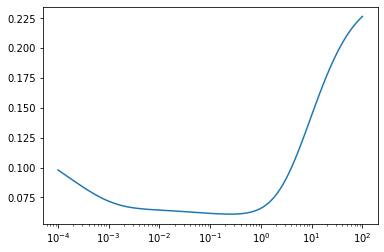

In [31]:
plt.semilogx(lambda_s,es)

In [32]:
lambda_s

array([1.00000000e-04, 1.14815362e-04, 1.31825674e-04, 1.51356125e-04,
       1.73780083e-04, 1.99526231e-04, 2.29086765e-04, 2.63026799e-04,
       3.01995172e-04, 3.46736850e-04, 3.98107171e-04, 4.57088190e-04,
       5.24807460e-04, 6.02559586e-04, 6.91830971e-04, 7.94328235e-04,
       9.12010839e-04, 1.04712855e-03, 1.20226443e-03, 1.38038426e-03,
       1.58489319e-03, 1.81970086e-03, 2.08929613e-03, 2.39883292e-03,
       2.75422870e-03, 3.16227766e-03, 3.63078055e-03, 4.16869383e-03,
       4.78630092e-03, 5.49540874e-03, 6.30957344e-03, 7.24435960e-03,
       8.31763771e-03, 9.54992586e-03, 1.09647820e-02, 1.25892541e-02,
       1.44543977e-02, 1.65958691e-02, 1.90546072e-02, 2.18776162e-02,
       2.51188643e-02, 2.88403150e-02, 3.31131121e-02, 3.80189396e-02,
       4.36515832e-02, 5.01187234e-02, 5.75439937e-02, 6.60693448e-02,
       7.58577575e-02, 8.70963590e-02, 1.00000000e-01, 1.14815362e-01,
       1.31825674e-01, 1.51356125e-01, 1.73780083e-01, 1.99526231e-01,
      